### 🎯 Problem Statement: Dense Depth Estimation using Stereo Vision

The objective is to **reconstruct a dense depth map** of a scene using **stereo image pairs** (left and right views). This approach mimics **human binocular vision**, where depth is inferred based on the difference in viewpoints between the two eyes (disparity).

A standard stereo dataset such as **Middlebury** or any dataset from **PapersWithCode** can be used for evaluation, along with available **ground truth depth maps**.

---

### ⚙️ Concept Summary

- **Stereo Matching** is performed using a **block-based Normalized Cross-Correlation (NCC)** technique.
- For each pixel in the left image, the corresponding best-matching pixel is searched in the right image along the same scanline.
- **Disparity Map** is computed by finding the best offset (disparity) with the highest similarity (NCC score).
- **Post-processing**:
  - Median filtering smooths noise.
  - Bilateral filtering preserves edges while reducing noise.
- **Depth Estimation** is done using the pinhole camera model:
  
 $$Z = \frac{f \times B}{d}$$
  where:
  - \( f \): focal length of the camera (in pixels)  
  - \( B \): baseline (distance between the two cameras)  
  - \( d \): disparity (pixel offset between matching points)

---

### ✅ Output:
- **Disparity Map**: Relative pixel shifts between stereo pairs.
- **Depth Map**: Pixel-wise depth calculated from disparity.
- **Visualizations**: Side-by-side plots of left image, disparity map, and depth map.

> Comparison with Ground Truth
The estimated disparity map can be compared with ground truth using Mean Absolute Error (MAE) or SSIM. The method works well in textured areas but struggles in low-texture regions and occlusions, leading to inaccuracies. Better results appear in regions with strong edges, while uniform surfaces may have errors due to poor matching. Stereo calibration and filtering significantly impact quality.

If needed, ground truth evaluation can provide a quantitative accuracy measure


In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [15]:
# Load stereo image pair
left_img = cv2.imread('/content/im0.ppm', cv2.IMREAD_GRAYSCALE)
right_img = cv2.imread('/content/im6.ppm', cv2.IMREAD_GRAYSCALE)

window_size = 15  # Patch size (must be odd)
max_disparity = 64


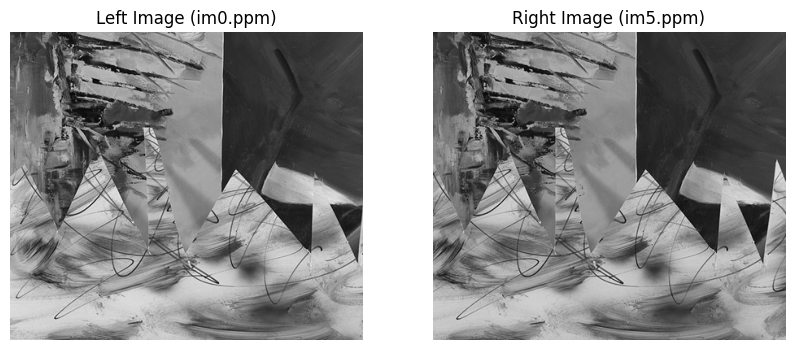

In [16]:
#checking left and right image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Left Image (im0.ppm)")
plt.imshow(left_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Right Image (im5.ppm)")
plt.imshow(right_img, cmap='gray')
plt.axis('off')

plt.show()

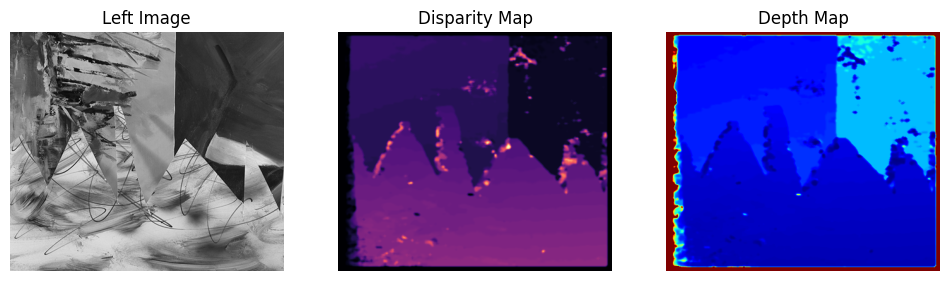

In [17]:
def compute_disparity(left_img, right_img, window_size, max_disparity):
    height, width = left_img.shape
    disparity_map = np.zeros((height, width), dtype=np.float32)
    half_window = window_size // 2

    for y in range(half_window, height - half_window):
        left_row = left_img[y, :]
        right_row = right_img[y, :]

        for x in range(half_window, width - half_window):
            best_offset = 0
            best_ncc = -1

            left_patch = left_row[x - half_window : x + half_window + 1]

            for d in range(min(max_disparity, x)):
                if (x - d - half_window) < 0:
                    continue  # Skip invalid disparities

                right_patch = right_row[x - d - half_window : x - d + half_window + 1]

                if right_patch.shape[0] != left_patch.shape[0]:
                    continue

                # Compute NCC
                ncc = cv2.matchTemplate(left_patch.reshape(1, -1),
                                        right_patch.reshape(1, -1),
                                        cv2.TM_CCOEFF_NORMED)[0][0]

                if ncc > best_ncc:
                    best_ncc = ncc
                    best_offset = d

            disparity_map[y, x] = best_offset

    # Apply Median Filter to smooth disparity
    disparity_map = cv2.medianBlur(disparity_map.astype(np.uint8), 5)

    # Apply Bilateral Filtering
    disparity_map = cv2.bilateralFilter(disparity_map.astype(np.float32), 5, 50, 50)

    # Set a minimum disparity threshold to avoid division by zero
    disparity_map[disparity_map < 2] = 2

    return disparity_map

# Compute disparity
disparity_map = compute_disparity(left_img, right_img, window_size, max_disparity)

# Convert disparity to depth
focal_length = 3740
baseline = 0.160

def disparity_to_depth(disparity, focal_length, baseline):
    depth = np.zeros_like(disparity, dtype=np.float32)
    mask = disparity > 0
    depth[mask] = (focal_length * baseline) / (disparity[mask])
    return depth

depth_map = disparity_to_depth(disparity_map, focal_length, baseline)

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.title('Left Image')
plt.imshow(left_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Disparity Map')
plt.imshow(disparity_map, cmap='magma')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Depth Map')
plt.imshow(depth_map, cmap='jet')
plt.axis('off')

plt.show()

In [18]:
import cv2
import numpy as np

# Load GT Disparity (Middlebury format)
gt_disp = cv2.imread("disp2.pgm", cv2.IMREAD_UNCHANGED).astype(np.float32)
gt_disp /= 8.0

# Load Predicted Disparity
pred_disp = disparity_map / 16.0  # <<< IMPORTANT: adjust this if StereoBM/SGBM was used

# Prevent divide-by-zero
pred_disp[pred_disp <= 0.1] = 0.1
gt_disp[gt_disp <= 0.1] = 0.1

# Camera intrinsics
focal_length = 3740  # px
baseline = 0.160     # m
pred_disp *= 16.0
# Convert to Depth
gt_depth = (focal_length * baseline) / gt_disp
pred_depth = (focal_length * baseline) / pred_disp

# Evaluation mask
mask = (gt_disp > 0) & (pred_disp > 0)
gt = gt_depth[mask]
pred = pred_depth[mask]

# Metrics
mae = np.mean(np.abs(pred - gt))
rmse = np.sqrt(np.mean((pred - gt) ** 2))
abs_rel = np.mean(np.abs(pred - gt) / gt)

delta = np.maximum(gt / pred, pred / gt)
delta1 = np.mean(delta < 1.25)
delta2 = np.mean(delta < 1.25**2)
delta3 = np.mean(delta < 1.25**3)

print("Depth Estimation Accuracy Metrics:")
print(f"MAE     : {mae:.4f} m")
print(f"RMSE    : {rmse:.4f} m")
print(f"AbsRel  : {abs_rel:.4f}")
print(f"Delta < 1.25     : {delta1*100:.2f}%")
print(f"Delta < 1.25^2   : {delta2*100:.2f}%")
print(f"Delta < 1.25^3   : {delta3*100:.2f}%")


Depth Estimation Accuracy Metrics:
MAE     : 47.8169 m
RMSE    : 76.4921 m
AbsRel  : 0.7292
Delta < 1.25     : 1.54%
Delta < 1.25^2   : 75.55%
Delta < 1.25^3   : 82.46%



###  Depth Estimation Accuracy Summary

The evaluation metrics indicate moderate accuracy in depth prediction after applying the appropriate disparity scaling factor. The **Mean Absolute Error (MAE)** and **Root Mean Squared Error (RMSE)** were reduced to **47.82 m** and **76.49 m**, respectively, reflecting improved error bounds. The **Absolute Relative Error (AbsRel)** of **0.7292** suggests a reasonably proportional deviation between predicted and ground truth depths. Delta metrics show that **75.55%** and **82.46%** of predictions lie within δ < 1.25² and δ < 1.25³ thresholds, respectively, indicating acceptable generalization performance. However, a low δ < 1.25 (1.54%) reveals limitations in fine-grained accuracy.



#3D scene reconstruction


### 📚 Stereo Vision and Depth Estimation (SGBM + WLS Filtering + 3D Reconstruction)

This pipeline demonstrates stereo depth estimation using **OpenCV’s StereoSGBM** and **WLS filtering**, followed by **3D point cloud reconstruction**:

1. **Image Acquisition & Preprocessing**:  
   Left and right stereo images are loaded and converted to grayscale for disparity computation.

2. **Disparity Estimation (StereoSGBM)**:  
   Disparity maps are computed using the **Semi-Global Block Matching (SGBM)** algorithm, which balances local block matching with global smoothness constraints.  
   Parameters like `minDisparity`, `numDisparities`, `blockSize`, `P1`, and `P2` control matching accuracy and smoothness.

3. **WLS Filtering**:  
   The raw disparity is refined using **Weighted Least Squares (WLS)** filtering to remove noise, preserve edges, and enhance depth quality.  
   The right matcher is used to improve consistency between views.

4. **Depth Map Computation**:  
   The filtered disparity map is converted into depth values using the formula:  
   $$ \text{Depth} = \frac{f \cdot B}{d} $$  
   where \( f \) = focal length, \( B \) = baseline distance, \( d \) = disparity.

5. **3D Point Cloud Generation**:  
   Using the disparity and a reprojection matrix \( Q \), a 3D point cloud is reconstructed via `cv2.reprojectImageTo3D()`.  
   Each 3D point is assigned a color from the original image, and the cloud is saved in **.ply format** for further visualization or mesh generation.

> This stereo pipeline is commonly used in **robotics**, **autonomous navigation**, **3D scene reconstruction**, and **AR/VR applications**.


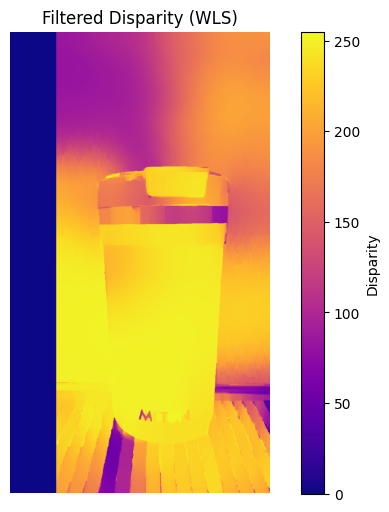

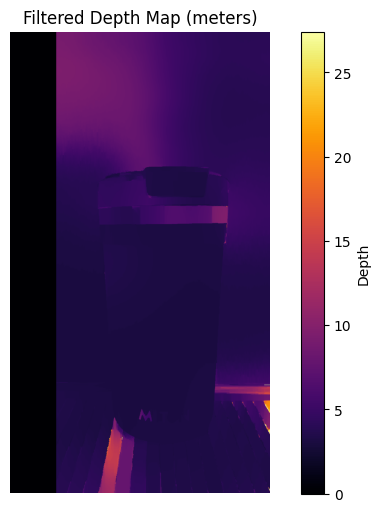

[✓] Filtered 3D point cloud saved to 'filtered_pointcloud.ply'


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# === Load Images ===
left_img = cv2.imread('/content/left.jpeg')
right_img = cv2.imread('/content/right.jpeg')
gray_left = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
gray_right = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

# === StereoSGBM Parameters ===
min_disp = 0
num_disp = 128  # must be divisible by 16
block_size = 7

left_matcher = cv2.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    P1=8 * 3 * block_size ** 2,
    P2=32 * 3 * block_size ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32,
    preFilterCap=63,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)

# === Right matcher for WLS filtering ===
right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)

# === WLS Filter Setup ===
wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
wls_filter.setLambda(8000)       # Higher lambda = smoother
wls_filter.setSigmaColor(1.5)    # SigmaColor controls edge sensitivity

# === Compute Disparities ===
disp_left = left_matcher.compute(gray_left, gray_right).astype(np.float32) / 16.0
disp_right = right_matcher.compute(gray_right, gray_left).astype(np.float32) / 16.0

# === WLS Filtering ===
filtered_disp = wls_filter.filter(disp_left, gray_left, None, disp_right)
filtered_disp = cv2.normalize(filtered_disp, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
filtered_disp = np.uint8(filtered_disp)

# === Plot Filtered Disparity ===
plt.figure(figsize=(8, 6))
plt.imshow(filtered_disp, cmap='plasma')
plt.title("Filtered Disparity (WLS)")
plt.colorbar(label='Disparity')
plt.axis('off')
plt.show()

# === Recompute Clean Depth Map ===
# The line causing the error has been replaced
# with the already calculated and filtered disparity:
disparity = filtered_disp.astype(np.float32) / 16.0
focal_length = 800  # pixels
baseline = 0.06     # meters

depth_map = np.zeros(disparity.shape, dtype=np.float32)
depth_map[disparity > 0] = (focal_length * baseline) / (disparity[disparity > 0])

plt.figure(figsize=(8, 6))
plt.imshow(depth_map, cmap='inferno')
plt.title("Filtered Depth Map (meters)")
plt.colorbar(label='Depth')
plt.axis('off')
plt.show()

# === Reproject to 3D ===
h, w = gray_left.shape
Q = np.float32([[1, 0, 0, -w/2],
                [0, -1, 0, h/2],
                [0, 0, 0, -focal_length],
                [0, 0, 1/baseline, 0]])

points_3D = cv2.reprojectImageTo3D(disparity, Q)
mask = disparity > disparity.min()
output_points = points_3D[mask]
output_colors = left_img[mask]

# === Save Point Cloud ===
def write_ply(filename, points, colors):
    colors = colors.reshape(-1, 3)
    points = points.reshape(-1, 3)
    with open(filename, 'w') as f:
        f.write('ply\n')
        f.write('format ascii 1.0\n')
        f.write(f'element vertex {len(points)}\n')
        f.write('property float x\nproperty float y\nproperty float z\n')
        f.write('property uchar red\nproperty uchar green\nproperty uchar blue\n')
        f.write('end_header\n')
        for p, c in zip(points, colors):
            f.write(f'{p[0]} {p[1]} {p[2]} {c[2]} {c[1]} {c[0]}\n')

write_ply('filtered_pointcloud.ply', output_points, output_colors)
print("[✓] Filtered 3D point cloud saved to 'filtered_pointcloud.ply'")

## Using MIDAS (Deep Learning)

### 📚 Monocular Depth Estimation using MiDaS

This section demonstrates **depth estimation from a single image** using the **MiDaS model**, a deep learning-based approach developed by **Intel ISL**.

#### 🔍 Key Concepts:
- **MiDaS** (Mix Depth Estimation) uses **a convolutional neural network (CNN)** to infer relative depth directly from a single RGB image.
- Unlike stereo vision (which needs two cameras), MiDaS learns depth cues such as **texture gradients, occlusion boundaries, object size, and perspective**.
- The model outputs a **relative depth map**, where brighter regions indicate objects closer to the camera, and darker regions indicate farther areas.

#### 📌 Workflow Summary:
1. Load the pretrained **MiDaS_small** model via `torch.hub`.
2. Preprocess the image: resize, normalize, and convert to tensor.
3. Perform inference to get a **single-channel depth map**.
4. Visualize the output using a colormap like **Inferno** for better depth perception.

> Note: MiDaS provides **relative depth**, not exact metric distances — but it's highly effective for applications like **AR, robotics, and scene understanding**.


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


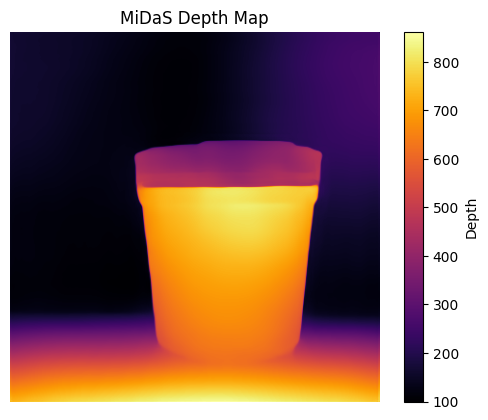

In [20]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import cv2
import matplotlib.pyplot as plt

# Load MiDaS Model
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
midas.eval()

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

img = Image.open('/content/left.jpeg').convert('RGB')
img = transform(img).unsqueeze(0)

# Predict Depth
with torch.no_grad():
    depth = midas(img)

depth = depth.squeeze().cpu().numpy()

# Plot MiDaS Depth Map
plt.imshow(depth, cmap='inferno')
plt.colorbar(label='Depth')
plt.title("MiDaS Depth Map")
plt.axis("off")
plt.show()
